# Bayesian Network Example

## Import Dependencies

In [50]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
import networkx as nx
import matplotlib.pyplot as plt

## Load/Clean Data
I'm using titanic data to demonstrate how we will construct a BayesNet for our project, but obviously once we have our data cleaned, we can use ours

In [24]:
# Load
train = pd.read_csv("titanic_data/train.csv")
test = pd.read_csv("titanic_data/test.csv")
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [25]:
# Clean
def clean_data(data):
    """
    Cleans a dataframe that looks like titanic data.

    Parameters:
        data (pd.DataFrame): A dataframe containing the data
    
    Returns:
        data (pd.DataFrame): A cleaned dataframe for use in a BayesNet
    """
    # To keep things simple, I'm only going to keep the pclass, sex, and age columns
    # but I'm going to bin the age column into a new column called seniority:{infant, child, adult, senior}
    data = data.copy() # Don't mess up original data
    data["Seniority"] = "adult"
    data.loc[data["Age"] <= 2, "Seniority"] = "infant"
    data.loc[data["Age"] < 18, "Seniority"] = "child"
    data.loc[data["Age"] >= 60, "Seniority"] = "senior"

    return data[["Pclass","Sex","Seniority"]]

train_survival = train["Survived"]
train = clean_data(train)
test = clean_data(test)
train

,Pclass,Sex,Seniority
0,3,male,adult
1,1,female,adult
2,3,female,adult
3,1,female,adult
4,3,male,adult
...,...,...,...
886,2,male,adult
887,1,female,adult
888,3,female,adult
889,1,male,adult


## Construct the BayesNet

In [26]:
# Instantiate
net = BayesianNetwork()

# Add a node for every variable we have
net.add_nodes_from(["Pclass", "Sex", "Seniority"])

# Add edges according to domain knowledge. I have arbitrarily chosen this structure. We will choose one that makes sense for us.
net.add_edges_from([("Sex", "Pclass"), ("Seniority","Pclass")])


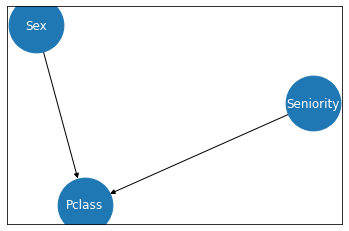

In [36]:
# Draw the network
nx.draw_networkx(net, node_size=3000, font_color="w")

## Train the BayesNet
Training is easy, we simply pass in the dataframe.

In [37]:
# For our project, we only have data for peptides that were correctly labeled.
# This is like only having the data for people who actually survived the titanic.
train = train[train_survival == 1]

# We simply call the .fit method
net.fit(train)

## View probability tables

In [49]:
print(net.get_cpds("Pclass"))

+-----------+---------------------+-----+--------------------+
| Seniority | Seniority(adult)    | ... | Seniority(senior)  |
+-----------+---------------------+-----+--------------------+
| Sex       | Sex(female)         | ... | Sex(male)          |
+-----------+---------------------+-----+--------------------+
| Pclass(1) | 0.42408376963350786 | ... | 0.6666666666666666 |
+-----------+---------------------+-----+--------------------+
| Pclass(2) | 0.3036649214659686  | ... | 0.3333333333333333 |
+-----------+---------------------+-----+--------------------+
| Pclass(3) | 0.27225130890052357 | ... | 0.0                |
+-----------+---------------------+-----+--------------------+
